In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datasets import load_dataset
import math

num_images = 100

In [2]:
dataset = load_dataset("mnist")

In [3]:
training_data = dataset['train']
labelled_data = [[] for i in range(10)]
for data_point in training_data:
    image = data_point['image']
    label = data_point['label']
    labelled_data[label].append(np.array(image).flatten())

labelled_data = np.array([labelled_data[i][:num_images] for i in range(10)], dtype='float64')
labelled_data = labelled_data.reshape(-1, labelled_data.shape[-1]).T
print(labelled_data.shape)

(784, 1000)


In [4]:
def kernelise(labelled_data, d):
    kernelised_data = np.zeros((10*num_images, 10*num_images))
    for i in range(10*num_images):
        for j in range(10*num_images):
            kernelised_data[i, j] = (1+np.dot(labelled_data[:, i], labelled_data[:, j]))**d
    return kernelised_data

def center_kernel(k_d):
    one_n = np.ones((10*num_images, 10*num_images))/(10*num_images)
    centered_kernelised_data = np.array(k_d - np.dot(one_n, k_d) - np.dot(k_d, one_n) + np.dot(np.dot(one_n, k_d), one_n))
    return centered_kernelised_data

d = [2, 3, 4]
kernelised_data = np.array([kernelise(labelled_data, power) for power in d])
centered_kernelised_data = np.array([center_kernel(kd) for kd in kernelised_data])

In [5]:
print(centered_kernelised_data.shape)

(3, 1000, 1000)


In [6]:
eigen_vectors, eigen_values = [], []
for ckd in centered_kernelised_data:
    eigen_vals, eigen_vecs = np.linalg.eig(ckd)
    descending_indices = np.argsort(eigen_vals)[::-1]
    eigen_vals = eigen_vals[descending_indices]
    eigen_vecs = eigen_vecs[:, descending_indices]  
    eigen_values.append(eigen_vals)
    eigen_vectors.append(eigen_vecs)
eigen_values = np.array(eigen_values)
eigen_vectors = np.array(eigen_vectors)

In [23]:
percentage_variance_explained = np.zeros((3, 1000))
print(percentage_variance_explained.shape)
eigen_sums = np.zeros(3)
for i, eigen_sum in enumerate(eigen_sums):
    eigen_sum = np.sum(eigen_values[i])
    percentage_variance_explained[i] = (eigen_values[i]/eigen_sum)*100

max_explained = np.zeros(3, dtype='int')
for i in range(3):
    temp = 0
    count = 0
    while temp < 95:
        temp += percentage_variance_explained[i, count]
        count += 1
    max_explained[i] = count

(3, 1000)


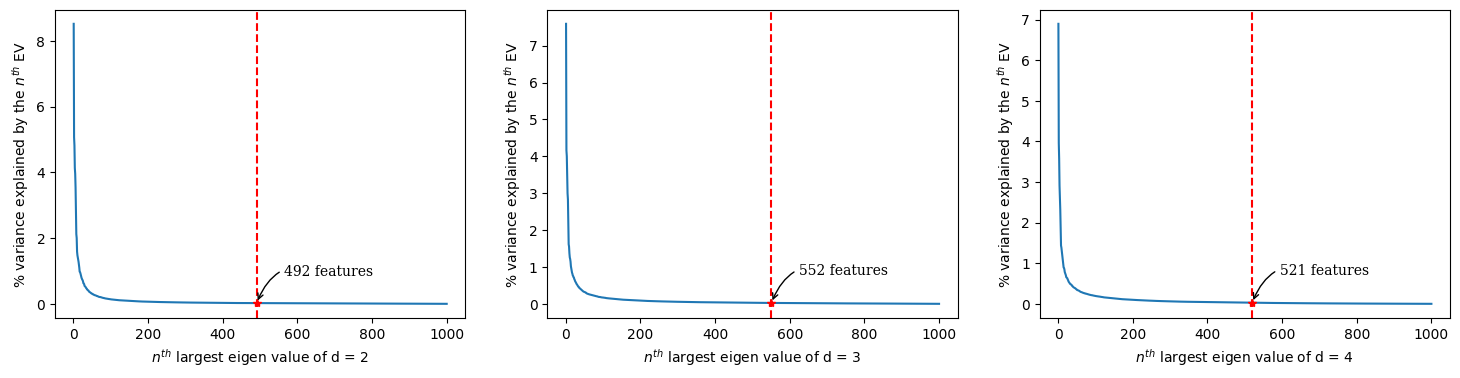

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for i, axis in enumerate(axes):
    axis.plot(np.linspace(1, 10*num_images, 10*num_images), percentage_variance_explained[i])
    axis.axvline(x=max_explained[i], color='red', linestyle='--')
    axis.plot(max_explained[i], percentage_variance_explained[i, max_explained[i]], 'r*')
    axis.annotate(str(max_explained[i] + 1) + " features", fontsize=10, family="serif",
        xy=(max_explained[i], percentage_variance_explained[i, max_explained[i]]), xycoords="data", 
        xytext=(+20, +20), textcoords="offset points",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.5"))
    axis.set_xlabel(r"$n^{th}$ largest eigen value of d = " + str(i+2))
    axis.set_ylabel(r"% variance explained by the $n^{th}$ EV")

plt.savefig('images/Q1/ker_var_explained')
plt.show()

In [8]:
alphas = np.array([[eigen_vectors[i, :, j]/math.sqrt(max(1, eigen_values[i, j])) for j in range(10*num_images)] for i in range(3)])

In [9]:
print(alphas.shape)
print(alphas[0, 0].shape)

(3, 1000, 1000)
(1000,)


In [10]:
projections = np.array([np.matmul(alphas[i], ckd.T)for i, ckd in enumerate(centered_kernelised_data)])
print(projections.shape)

(3, 1000, 1000)


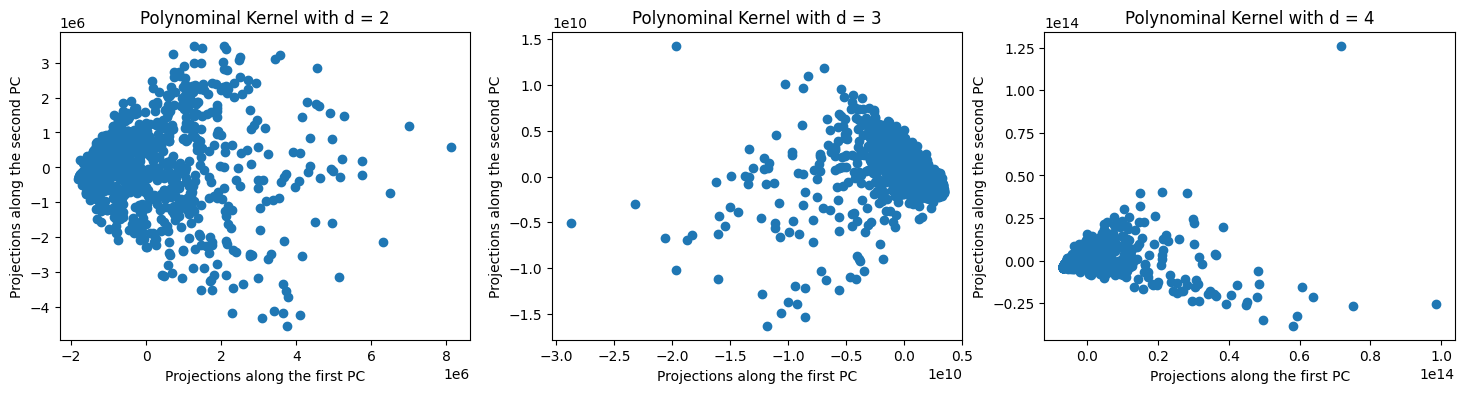

In [25]:

fig, axes = plt.subplots(1, 3, figsize = (18, 4))
for j in range(3):
    axes[j].scatter(projections[j, 0], projections[j, 1])
    axes[j].ticklabel_format(scilimits=(0, 4))
    axes[j].set_xlabel("Projections along the first PC")
    axes[j].set_ylabel("Projections along the second PC")
    axes[j].set_title("Polynominal Kernel with d = " + str(d[j]))

plt.savefig('images/Q1/w1vsw2poly')
plt.show()